In [2]:
%matplotlib inline
import os
os.chdir("..")
os.getcwd()

'/home/twoaday/research/deep-learning/visual-fashion-item-search'

In [3]:
from pymongo import MongoClient

from sklearn.decomposition import PCA
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import matplotlib.patches as patches
from PIL import Image
from PIL import ImageOps
import torch.utils.data as data
from keras.preprocessing import image
from tqdm import tqdm_notebook
from io import BytesIO
from torchvision import transforms
from torch.autograd import Variable

from sklearn.cluster import KMeans
from sklearn.externals import joblib
import os

from utils.image_utils import scale_image
import os
import glob
import requests
import numpy as np
import pandas as pd
import torch
from utils.composite_model_utils import load_extractor_model
from ai.feature_extraction import vectorize, get_deep_color_top_n
import logging

Using TensorFlow backend.
2019-09-08 14:33:59,849 : INFO : Checking directories...
2019-09-08 14:33:59,850 : INFO : Directories are set.
/usr/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")


In [4]:
DATA_PATH = '/run/media/twoaday/data-storag/data-sets/where2buyit/photos'
MODEL_PATH = '/home/twoaday/ai/models/fashion-vectorizer-converted.pth.tar'
NUM_CLUSTERS = 50
KNN_DF_MODEL_PATH = '/home/twoaday/ai/models/knn-deep-features-fashion.m'
PCA_DF_MODEL_PATH = '/home/twoaday/ai/models/pca-2-deep-features-fashion.m'
PCA_CF_MODEL_PATH = '/home/twoaday/ai/models/pca-2-color-features-fashion.m'

In [4]:
mongo_client = MongoClient()
products_collection = mongo_client["deep-fashion"]["products"]

In [5]:
extractor = load_extractor_model(MODEL_PATH)

In [6]:
result = [y for x in tqdm_notebook(os.walk(DATA_PATH), 'Walking through folders')
          for y in glob.glob(os.path.join(x[0], '*.jpg'))]

df_data_set = []
for file in tqdm_notebook(result, desc='Parsing files'):
    s = file.split('/')
    name, product, category = s[-1].replace('.jpg', ''), s[-2], s[-3]
    df_data_set.append([name, product, category, file])
df_data_set = pd.DataFrame(df_data_set)
df_data_set.columns = ['name', 'product', 'category', 'file']

df_query_set = df_data_set.loc[df_data_set.name == 'query'] 
df_data_set = df_data_set.loc[df_data_set.name != 'query']

In [7]:
df_data_set.count()

name        11638
product     11638
category    11638
file        11638
dtype: int64

In [9]:
rows = []

for _, row in tqdm_notebook(df_data_set.iterrows(), desc='Vectorizing', total=len(df_data_set)):
    try:
        deep_feat, color_feat = vectorize(extractor, row['file'])
        rows.append([row['name'],
                     row['product'],
                     row['category'],
                     row['file'],
                     deep_feat,
                     color_feat])
    except Exception as exp:
        logging.error('Can not vectorize {0}'.format(row['file']), exp)

In [9]:
knn = KMeans(n_clusters=NUM_CLUSTERS, n_jobs=8).fit([r[4] for r in rows])
joblib.dump(knn, KNN_DF_MODEL_PATH)
clusters = knn.predict([r[4] for r in rows])
rows = [r + [c] for r, c in tqdm_notebook(zip(rows, clusters), desc='Appending clusters')]

In [10]:
df_pca = PCA(n_components=2).fit([r[4] for r in rows])
joblib.dump(df_pca, PCA_DF_MODEL_PATH)

['/home/twoaday/ai/models/pca-2-deep-features-fashion.m']

In [11]:
cf_pca = PCA(n_components=2).fit([r[5] for r in rows])
joblib.dump(df_pca, PCA_CF_MODEL_PATH)

['/home/twoaday/ai/models/pca-2-color-features-fashion.m']

In [12]:
df_coords = df_pca.transform([r[4] for r in rows])
color_coords = cf_pca.transform([r[5] for r in rows])

In [13]:
for r, dfc, cfc in tqdm_notebook(zip(rows, df_coords, color_coords), 
                                     desc='Generating collection',
                                    total=len(rows)):
    try:
        if len(r) == 7:
            obj = {'imageName' : r[0],
               'product': r[1],
                'category': r[2],
                'filePath': r[3],
                'cluster': int(r[6]),
                'deepFeatures': [float(dfc[0]), float(dfc[1])],
                'colorFeatures': [float(cfc[0]), float(cfc[1])]
            }
            products_collection.insert_one(obj)
    except Exception as exp:
        logging.error(exp)

In [14]:
def search(row):
    deep_feat, color_feat = vectorize(extractor, row['file'])
    df_coord = df_pca.transform([deep_feat])[0]
    color_coord = cf_pca.transform([color_feat])[0]
    cn = knn.predict([deep_feat])[0]
    query = {
        'cluster':int(cn),
        'deepFeatures' :{ 
            '$near': {             
                '$geometry' : {
                    'type' : 'Point' ,
                    'coordinates' : [float(df_coord[0]), float(df_coord[1])] 
                }
            }        
        }     
     } 
    return products_collection.find(query).limit(3)

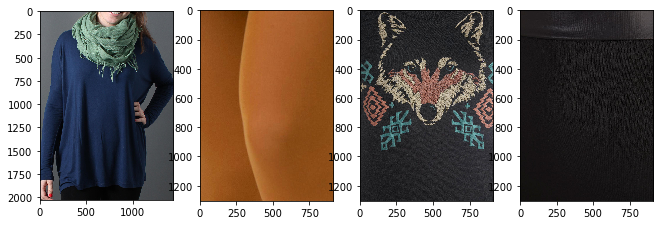

In [15]:
for _, r in df_query_set.sample(1).iterrows():
    search_result = [o['filePath'] for o in search(r)]
    
    # figure size in inches optional
    rcParams['figure.figsize'] = 11, 8
    # display images
    fig, ax = plt.subplots(1,4)
    ax[0].imshow(mpimg.imread(r['file']))
    indx = 1
    for img_path in search_result:
        ax[indx].imshow(mpimg.imread(img_path))
        indx += 1

bags
distances:
-0.43555449790434037
-0.4428006307962409
-0.47315616915296177
-0.4946047950452142
-0.5036746973468658


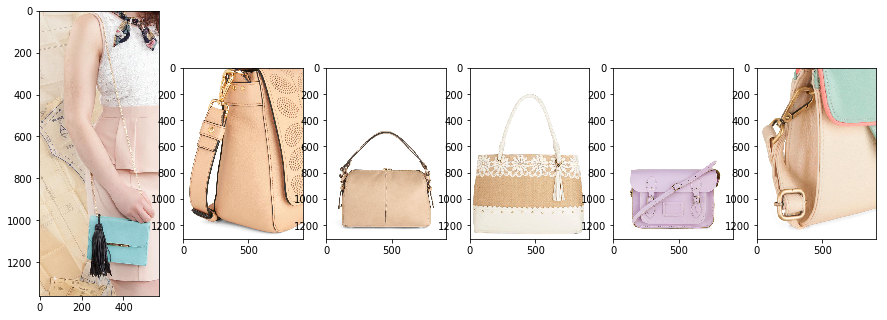

In [13]:
for _, anchor in df_query_set.sample(1).iterrows():
    deep_feat, color_feat = vectorize(extractor, anchor['file'])
    rs = [r for r in rows if r[2] == anchor['category']]
    similar = get_deep_color_top_n(deep_feat,
                                   color_feat,
                                   [r[4] for r in rs],
                                   [r[5] for r in rs], 
                                   [r[3] for r in rs],
                                   5)
    
    # figure size in inches optional
    rcParams['figure.figsize'] = 15, 11
    # display images
    fig, ax = plt.subplots(1, 6)
    ax[0].imshow(mpimg.imread(anchor['file']))
    indx = 1
    for sm_img in similar:
        ax[indx].imshow(mpimg.imread(sm_img[0]))
        indx += 1
    print(anchor['category'])
    print('distances:')
    for sm_img in similar:
        print(sm_img[1])
    